<div class="alert alert-success">
    -----
</div>

# Abstract

# Introduction

# `Analysis`

## Imports

In [1]:
import numpy as np

In [2]:
import pandas as pd

In [3]:
from scipy import stats as stats

In [4]:
import matplotlib.pyplot as plt

In [5]:
import seaborn as sns

In [6]:
import statsmodels.api as sm

In [7]:
import statsmodels.formula.api as smf

In [8]:
data = pd.read_csv('ccs2022.csv')

## Helper functions

In [9]:
def outlierFunc(x):
    q1 = np.quantile(x, 0.25)
    q3 = np.quantile(x, 0.75)
    
    iqr = q3-q1
    
    iqr_bounds = [q1 - (1.5 * iqr), q3 + (1.5 * iqr)]
    
    outliers = x[(x <= iqr_bounds[0]) | (x >= iqr_bounds[1])]
    
    return outliers

## Behavioral Analysis

#### First looks at data

In [10]:
data.sample(5)

,Unnamed: 0,num_features,task,trial,w0,w1,w2,w3,xf0,xf1,...,xj0,xj1,xj2,xj3,yf,yj,slow,J_pressed,decision_time,participant_id
2045,95,4,10,6,-0.364971,2.076510,-0.866252,0.029280,1.561284,-0.632310,...,0.435815,-0.672818,1.417237,0.223344,-3.040208,-2.777319,0,0,2209,6
3055,55,4,6,6,1.084871,0.155168,0.662582,-0.070925,-0.222060,-2.008312,...,3.699052,0.042297,0.101859,-0.146464,-0.199397,4.097436,1,0,3396,10
2016,66,3,7,7,0.190100,-0.482306,-0.175807,0.000000,-0.073376,0.152933,...,0.840285,-0.926768,0.142659,0.000000,-0.028298,0.581643,0,1,1557,6
292,142,2,15,3,-1.117463,-1.311147,0.000000,0.000000,0.234839,0.234668,...,0.516557,-1.282192,0.000000,0.000000,-0.570107,1.103908,0,1,1041,0
5266,16,2,2,7,1.016316,0.566453,0.000000,0.000000,0.746932,-0.990561,...,-2.199403,1.850506,0.000000,0.000000,0.198013,-1.187063,1,0,1453,17


In [11]:
list(data.columns)

['Unnamed: 0',
 'num_features',
 'task',
 'trial',
 'w0',
 'w1',
 'w2',
 'w3',
 'xf0',
 'xf1',
 'xf2',
 'xf3',
 'xj0',
 'xj1',
 'xj2',
 'xj3',
 'yf',
 'yj',
 'slow',
 'J_pressed',
 'decision_time',
 'participant_id']

#### Data preprocessing

Checking for empty values

In [12]:
data.isna().any()

Unnamed: 0        False
num_features      False
task              False
trial             False
w0                False
w1                False
w2                False
w3                False
xf0               False
xf1               False
xf2               False
xf3               False
xj0               False
xj1               False
xj2               False
xj3               False
yf                False
yj                False
slow              False
J_pressed         False
decision_time     False
participant_id    False
dtype: bool

Adding columns for a global trial counter and participant accuracy 

In [13]:
data.rename(columns={'Unnamed: 0':'global_trial'}, inplace=True)
data['correct'] = (data['J_pressed'] == (data['yj'] > data['yf'])).map(int)

#### Outliers

The most important columns for analysis are participant accuracy and reaction time as these reflect performance in the experiment.

In [14]:
per_correct = data['correct'].mean()
par_correct = data.groupby('participant_id').correct.mean()

Average accuracy: 0.6464912280701754 

                 correct
participant_id          
0               0.693333
1               0.623333
2               0.530000
3               0.676667
4               0.610000
5               0.603333
6               0.653333
7               0.650000
8               0.583333
9               0.580000
10              0.596667
11              0.570000
12              0.603333
13              0.600000
14              0.706667
15              0.763333
16              0.676667
17              0.673333
18              0.890000 



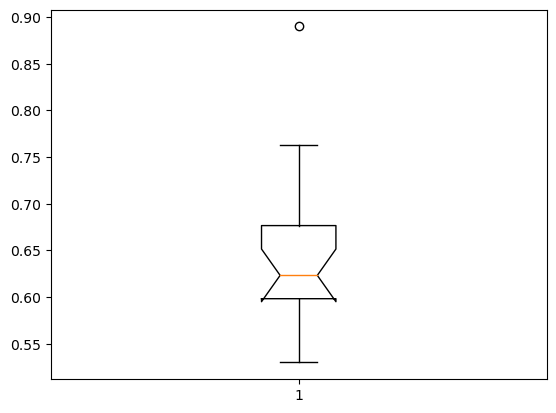

In [15]:
print("Average accuracy:", per_correct, "\n")
print(par_correct.to_frame(), "\n")

corrextBox = plt.boxplot(par_correct, notch=True)
corrextBox;

After taking a look at the accuracy data we found one outlier performing well above others. We identify this as participant number 18.

In [16]:
outlierFunc(par_correct)

participant_id
18    0.89
Name: correct, dtype: float64

In [17]:
par_RT = data.groupby('participant_id').decision_time.mean()

                decision_time
participant_id               
0                 1368.210000
1                 1875.830000
2                 1958.940000
3                 1801.540000
4                 2566.550000
5                 2101.280000
6                 2321.813333
7                 2517.000000
8                 2316.123333
9                 1808.473333
10                2284.053333
11                3072.210000
12                2444.743333
13                1985.430000
14                2341.020000
15                1511.383333
16                2189.913333
17                1896.943333
18                 675.160000 



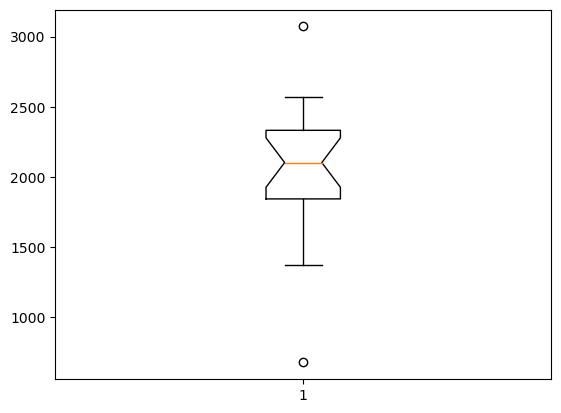

In [18]:
print(par_RT.to_frame(), "\n")
RTBox = plt.boxplot(par_RT, notch=True)
RTBox;

After reviewing reaction time data we noticed two participants who had reaction times noticeably beyond others. We identified these as participants 18 and 11 with exceptionally low and high reaction times, respectively.

In [19]:
outlierFunc(par_RT)

participant_id
11    3072.21
18     675.16
Name: decision_time, dtype: float64

#### Excluding outliers

We exclude participant 18 due to having both higher accuracy and lower RT than all other participants. We decided to keep participant 11 in the data as despite their slow reaction times their performance was not exceptional.

In [20]:
data = data[data['participant_id'] != 18]
per_correct = data['correct'].mean()
par_correct = data.groupby('participant_id').correct.mean()
par_RT = data.groupby('participant_id').decision_time.mean()

#### Do participants perform better than chance?

In [21]:
print("Average accuracy:", per_correct, "\n")
t_par, p_par = stats.ttest_1samp(par_correct, 0.5)
print("t =", t_par, "p =", p_par)

Average accuracy: 0.632962962962963 

t = 9.755663611634345 p = 2.2222087595716773e-08


#### Do they improve over trials within each round?

In [22]:
trial_correct = data.groupby('trial').correct.mean()
trial_correct

trial
1     0.487037
2     0.659259
3     0.614815
4     0.600000
5     0.640741
6     0.659259
7     0.651852
8     0.651852
9     0.661111
10    0.703704
Name: correct, dtype: float64

In [23]:
trial_mod = smf.ols(formula="correct ~ trial", data=data).fit()
print(trial_mod.summary())

                            OLS Regression Results                            
Dep. Variable:                correct   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     38.24
Date:                Sun, 02 Oct 2022   Prob (F-statistic):           6.72e-10
Time:                        15:31:29   Log-Likelihood:                -3702.2
No. Observations:                5400   AIC:                             7408.
Df Residuals:                    5398   BIC:                             7422.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5556      0.014     39.340      0.0

#### Do they improve over rounds?

In [24]:
task_correct = data.groupby('task').correct.mean()
task_correct

task
1     0.580556
2     0.594444
3     0.638889
4     0.663889
5     0.630556
6     0.633333
7     0.611111
8     0.680556
9     0.686111
10    0.597222
11    0.650000
12    0.616667
13    0.636111
14    0.655556
15    0.619444
Name: correct, dtype: float64

In [25]:
task_mod = smf.ols(formula="correct ~ task", data=data).fit()
print(task_mod.summary())

                            OLS Regression Results                            
Dep. Variable:                correct   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.368
Date:                Sun, 02 Oct 2022   Prob (F-statistic):              0.242
Time:                        15:31:29   Log-Likelihood:                -3720.6
No. Observations:                5400   AIC:                             7445.
Df Residuals:                    5398   BIC:                             7458.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6188      0.014     44.824      0.0

#### How does the number of observed features affect performance?

In [26]:
feat_correct = data.groupby('num_features').correct.mean()
feat_correct

num_features
2    0.684444
3    0.616111
4    0.598333
Name: correct, dtype: float64

In [27]:
feat_mod = smf.ols(formula="correct ~ num_features", data=data).fit()
print(feat_mod.summary())

                            OLS Regression Results                            
Dep. Variable:                correct   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     28.87
Date:                Sun, 02 Oct 2022   Prob (F-statistic):           8.07e-08
Time:                        15:31:29   Log-Likelihood:                -3706.8
No. Observations:                5400   AIC:                             7418.
Df Residuals:                    5398   BIC:                             7431.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.7621      0.025     30.590   

#### How does time pressure affect performance?

In [28]:
slow_correct = data.groupby('slow').correct.mean()
slow_correct

slow
0    0.610000
1    0.655926
Name: correct, dtype: float64

In [29]:
t_slow, p_slow = stats.ttest_ind(data[data['slow'] == 0].correct, data[data['slow'] == 1].correct)
print("t =", t_slow, "p =", p_slow)

t = -3.5042387629481064 p = 0.00046163035172905114


#### RT Correlation

In [30]:
data.groupby('participant_id')[['decision_time', 'correct']].mean()

,decision_time,correct
participant_id,,
0,1368.210000,0.693333
1,1875.830000,0.623333
2,1958.940000,0.530000
3,1801.540000,0.676667
4,2566.550000,0.610000
5,2101.280000,0.603333
6,2321.813333,0.653333
7,2517.000000,0.650000
8,2316.123333,0.583333


In [32]:
stats.pearsonr(par_correct, par_RT)

(-0.4313358070848609, 0.07389986782594637)

In [33]:
RT_mod = smf.ols(formula="correct ~ decision_time", data=data).fit()
print(RT_mod.summary())

                            OLS Regression Results                            
Dep. Variable:                correct   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     62.03
Date:                Sun, 02 Oct 2022   Prob (F-statistic):           4.06e-15
Time:                        15:32:01   Log-Likelihood:                -3690.4
No. Observations:                5400   AIC:                             7385.
Df Residuals:                    5398   BIC:                             7398.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.7315      0.014     51.839

We found a significant negative relationship between accuracy and decision time (

#### Bigression

In [34]:
big_mod = smf.ols(formula="correct ~ num_features * C(slow) * decision_time", data=data).fit()
print(big_mod.summary())

                            OLS Regression Results                            
Dep. Variable:                correct   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     23.05
Date:                Sun, 02 Oct 2022   Prob (F-statistic):           5.06e-31
Time:                        15:32:01   Log-Likelihood:                -3641.6
No. Observations:                5400   AIC:                             7299.
Df Residuals:                    5392   BIC:                             7352.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

## Parameter Fitting

`Look at the resulting parameters and try to answer the following questions`

### Recorla-Wagner

> • Does time pressure lead to slower learning?

> • Does time pressure lead to more noisy decisions?

### Kalman Filter

> • Does time pressure lead to slower learning?

> • Does time pressure lead to more noisy decisions?

### Error Model

> • Does time pressure lead to slower learning?

> • Does time pressure lead to more noisy decisions?

### <.....> Model

> • Does time pressure lead to slower learning?

> • Does time pressure lead to more noisy decisions?

#### Random policy

In [35]:
N = len(pd.unique(data['participant_id']))

In [36]:
RP_BIC = np.full(N, 0 - 2 * 300 * np.log(0.5))
RP_BIC

array([415.88830834, 415.88830834, 415.88830834, 415.88830834,
       415.88830834, 415.88830834, 415.88830834, 415.88830834,
       415.88830834, 415.88830834, 415.88830834, 415.88830834,
       415.88830834, 415.88830834, 415.88830834, 415.88830834,
       415.88830834, 415.88830834])

## Model Comparison

> •  Which model explains the human data best?

In [37]:
RW_BIC = np.random.rand(N) * 1000
KF_BIC = np.random.rand(N) * 1000

In [38]:
all_BIC = np.array([RW_BIC, KF_BIC, RP_BIC])

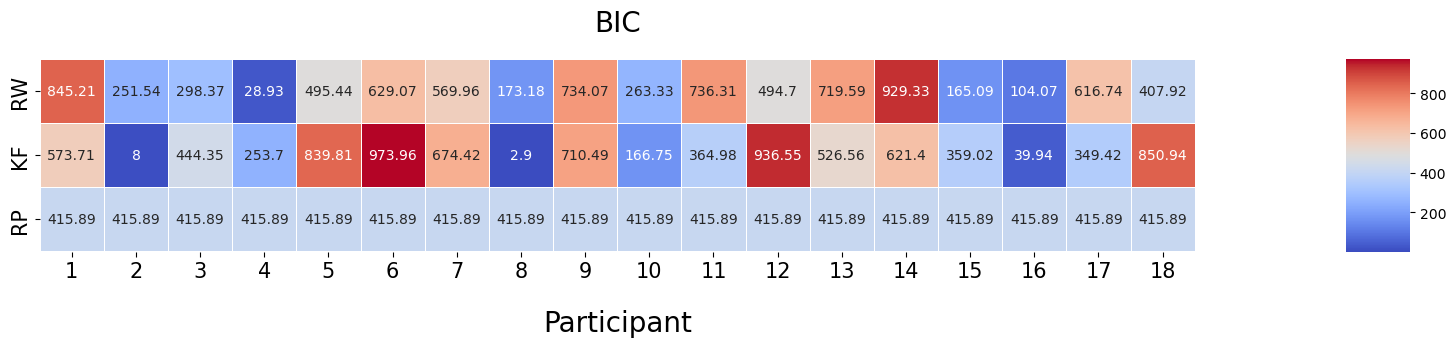

In [39]:
all_BICr = [np.around(num,2) for num in all_BIC]

f, (ax, cbar_ax) = plt.subplots(1,2, gridspec_kw = {'width_ratios': [0.95, 0.05]}, figsize = (18,2))
f.set_figheight(2.5)

sns.heatmap(all_BICr, cmap = 'coolwarm', linewidths = 0.5, square = True, annot = True, fmt = 'g',
            ax = ax, cbar_ax = cbar_ax)

ax.set_xticklabels(np.arange(N) + 1, fontsize = 15);
ax.set_yticklabels(['RW', 'KF', 'RP'], fontsize = 15);
ax.set_xlabel('Participant', labelpad = 20, fontsize = 20);
ax.set_title('BIC', pad = 20, fontsize = 20);

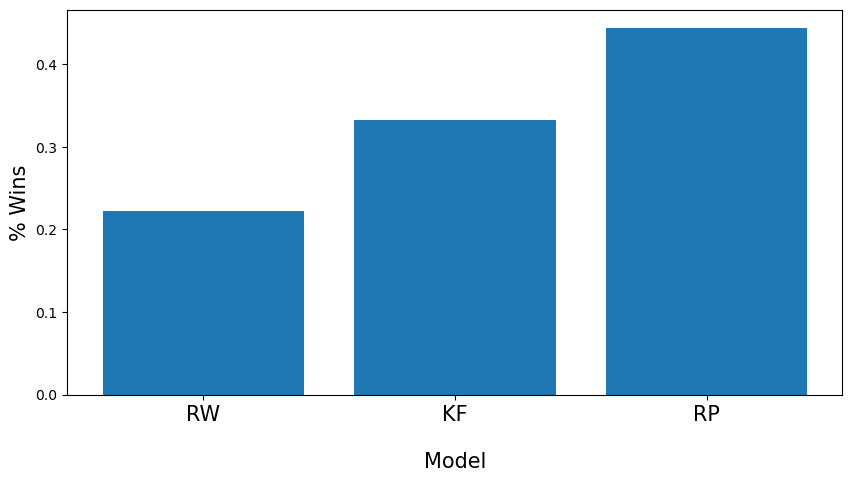

In [40]:
model_wins = np.argmin(all_BIC, 0)
model_plot = np.histogram(model_wins, [0, 1, 2, 3])[0] / N

plt.figure(figsize=(10,5))

plt.bar(['RW','KF','RP'], model_plot);
plt.xticks(fontsize = 15);
plt.xlabel('Model', labelpad = 20, fontsize = 15);
plt.ylabel('% Wins', fontsize=15);

> • Does time pressure lead to simpler learning strategies?

# Methods

# Results

# Discussion

# References